In [219]:
%matplotlib inline
#----------------------------------------------------------------------
#------------------------- IMPORT LIBRARIES ---------------------------
import json # reading geojson files
import matplotlib.pyplot as plt # plotting data
from shapely.geometry import asShape # manipulating geometry
from descartes import PolygonPatch # integrating geom object to matplot
import pandas as pd
import numpy as np
from unidecode import unidecode

In [246]:
# Data
murders_df = pd.read_csv("./data/asesinatos.csv", sep=";")
slaughters_df = pd.read_csv("./data/masacres.csv", sep=";")

In [247]:
murders_df.head(2)

,Día,Mes,Año,Departamento,Municipio,Lugar de Ocurrencia,Tipo de Implicado (1),Tipo de Implicado (2),Nº Víctimas,Fuente,Unnamed: 10
0,6,1,1981.0,Santander,Barrancabermeja,NaN,Grupo Armado No Identificado,Grupo Armado No Identificado,1,Itinerario de la Represión Oficial y Militar e...,NaN
1,7,1,1981.0,Huila,Algeciras,NaN,Grupos Paramilitares,Grupos Paramilitares,2,Itinerario de la Represión Oficial y Militar e...,NaN


In [248]:
slaughters_df.head(2)

,Día,Mes,Año,Departamento,Municipio,Lugar de Ocurrencia,Tipo de Implicado,Nº Víctimas,Fuente,Unnamed: 9
0,2,10,1980.0,Caquetá,Puerto Rico,Vereda El Topacio,Grupos Paramilitares,5,Enterrar y Callar Pp. 109 CPDH,NaN
1,24,10,1980.0,Arauca,Tame,IPD La Arabia,Fuerza Pública-Ejército Nacional,5,Enterrar y Callar Pp. 89 Boletín de Prensa CPD...,NaN


In [224]:
#Clean
murders_df = murders_df[~murders_df["Departamento"].isnull()]
slaughters_df = slaughters_df[~slaughters_df["Departamento"].isnull()]
murders_df = murders_df[~murders_df["Nº Víctimas"].isnull()]
slaughters_df = slaughters_df[~slaughters_df["Nº Víctimas"].isnull()]
murders_df["Departamento"] = murders_df["Departamento"].apply(lambda x:x.strip())
murders_df["Nº Víctimas"] = murders_df["Nº Víctimas"].apply(lambda x:x.replace("´1","1"))
murders_df["Departamento"] = murders_df["Departamento"].apply(lambda x:x.replace("Choco","Chocó"))
slaughters_df["Departamento"] = slaughters_df["Departamento"].apply(lambda x:x.replace("Quindio","Quindío"))
murders_df["Departamento"] = murders_df["Departamento"].apply(lambda x:x.replace("meta","Meta"))
murders_df["Departamento"] = murders_df["Departamento"].apply(lambda x:x.replace("César","Cesar"))
slaughters_df["Departamento"] = slaughters_df["Departamento"].apply(lambda x:x.strip())
departaments_mu = set(murders_df["Departamento"].unique())
departaments_sl = set(slaughters_df["Departamento"].unique())
weird_set = departaments_mu - departaments_sl - set(["Vaupés", "San Andrés Isla"]) | set(["Exterior"])
murders_df = murders_df[~murders_df["Departamento"].isin(weird_set)]
weird_set = departaments_sl - departaments_mu - set(["Guainía"]) | set(["Exterior"])
slaughters_df = slaughters_df[~slaughters_df["Departamento"].isin(weird_set)]

In [225]:
#Filter
murders_df = murders_df[["Departamento","Nº Víctimas"]]
murders_df.columns = ["depto","count"]
murders_df["count"] = murders_df["count"].astype(int)
slaughters_df = slaughters_df[["Departamento","Nº Víctimas"]]
slaughters_df.columns = ["depto","count"]

In [226]:
#Join
print(len(murders_df))
print(len(slaughters_df))
df = murders_df.append(slaughters_df)
print(len(df))

16304
1976
18280


In [227]:
df.head(2)

,depto,count
0,Santander,1
1,Huila,2


In [242]:
#Names
df["depto"] = df["depto"].apply(lambda x:unidecode(x).upper())
df["depto"] = df["depto"].apply(lambda x:x.replace("DISTRITO CAPITAL","SANTAFE DE BOGOTA D.C"))
df["depto"] = df["depto"].apply(lambda x:x.replace("SAN ANDRES ISLA","ARCHIPIELAGO DE SAN ANDRES PROVIDENCIA Y SANTA CATALINA"))
df["depto"] = df["depto"].apply(lambda x:x.replace("NARINO","NARIÑO"))

In [255]:
#Group
df_sum = df.groupby("depto").sum()
deptos = set(list(df_sum.index))

In [244]:
df_sum

,count
depto,
ANTIOQUIA,8780
ARAUCA,793
ARCHIPIELAGO DE SAN ANDRES PROVIDENCIA Y SANTA CATALINA,1
ATLANTICO,337
BOLIVAR,1822
BOYACA,452
CALDAS,769
CAQUETA,559
CASANARE,309


<bound method _AxesBase.clear of <matplotlib.axes._subplots.AxesSubplot object at 0x7efc71cadda0>>

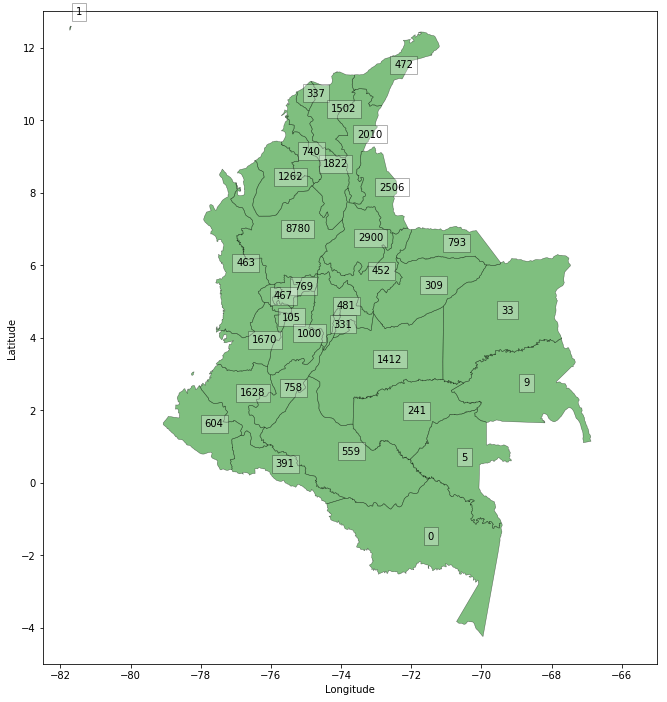

In [259]:
#------------------------- LOAD THE DATA -----------------------------
data = json.load(open("colombia.geojson")) # from data folder.

# initiate the plot axes
fig = plt.figure(figsize=(11, 12)) # create a figure to contain the plot elements
ax = fig.gca(xlabel="Longitude", ylabel="Latitude")
ax.set_xlim([-82.5,-65])
ax.set_ylim([-5,13])

# loop through the features plotting polygon centroid
for feat in data["features"]:
    depto = feat["properties"]["NOMBRE_DPT"]
    count = 0
    if depto in deptos:
        count = int(df_sum.loc[depto])
    # convert the geometry to shapely
    geom = asShape(feat["geometry"])
    # obtain the coordinates of the feature's centroid
    x, y = geom.centroid.x, geom.centroid.y
    ax.text(x, y, str(count), fontsize=10, bbox = dict(fc='w',
            alpha=0.3))
    # plot the centroids
    # ax.plot(x, y, 'bo')
    # plot the polygon features: type help(PolygonPatch) for more args
    ax.add_patch(PolygonPatch(feat["geometry"], fc='green', ec='black',
                alpha=0.5, lw=0.5, ls='-', zorder=2))
ax.clear